In [29]:
'''
Чтобы запустить программу необходимо прописать все параметры и запустить последовательно все ячейки.
Программа по введенным параметрам строит оптимальный способ коммуникации, возвращает таблицу с ID клиента и 
способом коммуникации для него (target 1 - sms), (target 2 - email) 

BUDGET - ограничение на бюджет, будет подобрана оптимальная стратегия, бюджет которой чуть больше чем BUDGET

SMS_COST - стоимость одного SMS (target 1)
EMAIL_COST - стоимость одного EMAIL (target 2)

PATH_TRAIN - путь к обучающим данным
PATH_TEST - путь к данным, на которых наша модель будет тестироваться
PATH_TO_RESULTS - путь, куда сохраняется стратегия для коммуникации
'''

BUDGET = 10000

SMS_COST = 2.
EMAIL_COST = 0.01

PATH_TRAIN = '../data/WORK_bank_data_train.csv'
PATH_TEST = '../data/WORK_WORK_BANK_DATA_test_sample.csv'
PATH_TO_RESULTS = '../data/results.csv'

def prepare_data(df, is_train=True):
    def do_one_hot_encoding(data, columns):
        for column in columns:
            tmp = pd.get_dummies(data[column], prefix=column)
            data = data.drop(columns=[column])
            data = data.join(tmp)
        return data

    def transformation_yes_no_to_1_0(data, columns):
        for column in columns:
            data[column] = 1 * (data[column] == 'Yes')
        return data
    
    AGE_MEAN = df_train['Age'].mean()
    LIFETIME_MEAN = df_train['Lifetime'].mean()
    
    df['Age'].fillna(AGE_MEAN, inplace=True)
    df['Lifetime'].fillna(LIFETIME_MEAN, inplace=True)
    
    if not is_train:
        df.rename(columns={
            'Ind_House_hold' : 'Ind_Household'
        }, inplace=True)
    
    columns_to_delete = [
        'Ind_email',
        'Ind_phone'
    ]
    
    columns_to_label_encoding = [
        'Ind_Household',
        'Ind_deposit',                
        'Ind_salary'
    ]

    if is_train:
        df.drop(columns=columns_to_delete, inplace=True)
        columns_to_label_encoding += ['Target1', 'Target2']

    df = transformation_yes_no_to_1_0(df, columns=columns_to_label_encoding)
    
    columns_to_one_hot_encoding = [
        'Segment', 
        'Region', 
        'District', 
        'Age_group', 
        'Gender'
    ]
    
    df = do_one_hot_encoding(df, columns=columns_to_one_hot_encoding)
    
    return df

In [30]:
columns_0_to_drop = [
    'ID', 'trans_6_month', 'trans_9_month', 'trans_12_month',
    'trans_3_month', 'Region_Scottish', 'Region_South West',
    'Region_Unknown', 'District_01', 'District_02', 'District_03',
    'District_04', 'District_05', 'District_06', 'District_07',
    'District_08', 'District_09', 'District_10', 'District_11',
    'District_12', 'District_13', 'District_14', 'District_15',
    'District_16', 'District_17', 'District_18', 'District_19',
    'District_20', 'District_21', 'District_22', 'District_23',
    'District_24', 'District_25', 'District_26', 'District_27',
    'District_28', 'District_29', 'District_30', 'District_31',
    'District_32', 'District_33', 'District_34', 'District_35',
    'District_36', 'District_37', 'District_38', 'District_39',
    'District_40', 'District_41', 'District_42', 'District_43',
    'District_44', 'District_45', 'District_46', 'District_47',
    'District_48', 'District_49', 'District_50', 'District_51',
    'District_52', 'District_53', 'District_54', 'District_55',
    'District_U', 'Age_group_unknown'
]

columns_1_to_drop = [
    'ID', 'Ind_salary', 'trans_6_month', 'trans_9_month', 'trans_12_month',
    'trans_3_month', 'Segment_Platinum', 'Region_Scottish',
    'Region_South West', 'Region_Unknown', 'District_01', 'District_02',
    'District_03', 'District_04', 'District_05', 'District_06',
    'District_07', 'District_08', 'District_09', 'District_10',
    'District_11', 'District_12', 'District_13', 'District_14',
    'District_15', 'District_16', 'District_17', 'District_18',
    'District_19', 'District_20', 'District_21', 'District_22',
    'District_23', 'District_24', 'District_25', 'District_26',
    'District_27', 'District_28', 'District_29', 'District_30',
    'District_31', 'District_32', 'District_33', 'District_34',
    'District_35', 'District_36', 'District_37', 'District_38',
    'District_39', 'District_40', 'District_41', 'District_42',
    'District_43', 'District_44', 'District_45', 'District_46',
    'District_47', 'District_48', 'District_49', 'District_50',
    'District_51', 'District_52', 'District_53', 'District_54',
    'District_55', 'District_U', 'Age_group_unknown'
]

In [31]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import xgboost

pd.options.display.max_columns = 40
pd.options.display.max_rows = 85

df_train = pd.read_csv(PATH_TRAIN, encoding='cp1251',
                       engine='python', sep=';', index_col=None, header=0)
df_test = pd.read_csv(PATH_TEST, encoding='cp1251',
                      engine='python', sep=';', index_col=None, header=0)
    
df_train = prepare_data(df_train)
df_test = prepare_data(df_test, False)

X, y0, y1 = (df_train.drop(columns=['Target1', 'Target2']),
             df_train.loc[:, ['Target1']],
             df_train.loc[:, ['Target2']])

X0 = X.drop(columns=columns_0_to_drop)


### Best model for Target1 ###

clf0 = xgboost.XGBClassifier(
    use_label_encoder=False,
    n_estimators=100,
    objective='binary:logistic',
    max_depth=3,
    eta=0.1,
)

clf0.fit(X0, y0)
probs0 = clf0.predict_proba(df_test.drop(columns=columns_0_to_drop))
preds0 = probs0[:, 1]

### Best model for Target2 ###

clf1 = xgboost.XGBClassifier(
    use_label_encoder=False,
    n_estimators=100,
    objective='binary:logistic',
    max_depth=3,
    eta=0.1,
)

X1 = X.drop(columns=columns_1_to_drop)

clf1.fit(X1, y1)

### Сonstruction of technical parameters ###

probs1 = clf1.predict_proba(df_test.drop(columns=columns_1_to_drop))
preds1 = probs1[:, 1]

df_test['prob1'] = pd.Series(preds0, index=df_test.index)
df_test['prob2'] = pd.Series(preds1, index=df_test.index)

df_test['prob1_inc'] = df_test['prob1'] / SMS_COST
df_test['prob2_inc'] = df_test['prob2'] / EMAIL_COST
df_test['2_to_1_inc'] = (df_test['prob1'] - df_test['prob2']) / (SMS_COST - EMAIL_COST)
df_test['for_sort'] = df_test[['prob1_inc', 'prob2_inc']].max(axis = 1)

[10:52:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
### Function for getting the final dataframe ###

def get_communication_df(df):
    communication_types = []
    ids = []
    num_target_1 = 0
    num_target_2 = 0
    min_proba_1 = 1.
    min_proba_2 = 1.
    for i in range(len(df)):
        if df.iloc[i]['communication'] == 'None':
            continue
        elif df.iloc[i]['communication'] == 'sms':
            num_target_1 += 1
            min_proba_1 = min(min_proba_1, df.iloc[i]['prob1'])
            ids.append(df.iloc[i]['ID'])
            communication_types.append('target 1')
        else:
            num_target_2 += 1
            min_proba_2 = min(min_proba_2, df.iloc[i]['prob2'])
            ids.append(df.iloc[i]['ID'])
            communication_types.append('target 2')

    res = pd.DataFrame({'ID': ids, 'type': communication_types})
    return res, num_target_1, num_target_2, min_proba_1, min_proba_2

In [33]:
### Strategy algorithm ###

df_test['communication'] = 'None'
df_test = df_test.sort_values(by=['for_sort'], ascending=False)
df_test = df_test.reset_index(drop=True)
budgets = [0]
expected_responses = [0]
increases = []
indecies = []
index_max = -1
i = 0
email = 0
sms = 0
email_to_sms = 0
communication_df = None
while i < df_test.shape[0]:
    if len(increases) != 0 and index_max == -1:
        index_max = np.argmax(np.array(increases))
    if index_max != -1 and (increases[index_max] > df_test.iloc[i]['prob1_inc']) and \
       (increases[index_max] > df_test.iloc[i]['prob2_inc']):
        budgets.append(budgets[-1] + SMS_COST - EMAIL_COST)
        expected_responses.append(expected_responses[-1] + df_test.iloc[indecies[index_max]]['prob1'] - 
                                  df_test.iloc[indecies[index_max]]['prob2'])
        increases.pop(index_max)
        df_test.at[indecies[index_max], 'communication'] = 'sms'
        indecies.pop(index_max)
        index_max = -1
        email_to_sms += 1
    elif df_test.iloc[i]['prob1_inc'] > df_test.iloc[i]['prob2_inc']:
        budgets.append(budgets[-1] + SMS_COST)
        expected_responses.append(expected_responses[-1] + df_test.iloc[i]['prob1'])
        df_test.at[i, 'communication'] = 'sms'
        sms += 1
        i += 1
    else:
        budgets.append(budgets[-1] + EMAIL_COST)
        expected_responses.append(expected_responses[-1] + df_test.iloc[i]['prob2'])
        increases.append(df_test.iloc[i]['2_to_1_inc'])
        indecies.append(i)
        if increases[-1] > index_max:
            index_max = len(increases) - 1
        df_test.at[i, 'communication'] = 'email'
        email += 1
        i += 1
    if communication_df is None and budgets[-1] > BUDGET:
        communication_df, num_target_1, num_target_2, cut_off_1, cut_off_2 = get_communication_df(df_test)
        res_budget = budgets[-1]
        res_response = expected_responses[-1]
    assert len(budgets) == len(expected_responses)

while len(increases) != 0:
    if len(increases) != 0 and index_max == -1:
        index_max = np.argmax(np.array(increases))
    assert len(budgets) == len(expected_responses)
    budgets.append(budgets[-1] + SMS_COST - EMAIL_COST)
    expected_responses.append(expected_responses[-1] +
                              df_test.iloc[indecies[index_max]]['prob1'] - 
                                  df_test.iloc[indecies[index_max]]['prob2'])
    increases.pop(index_max)
    df_test.at[indecies[index_max], 'communication'] = 'sms'
    indecies.pop(index_max)
    index_max = -1
    email_to_sms += 1
    if communication_df is None and budgets[-1] > BUDGET:
        communication_df, num_target_1, num_target_2, cut_off_1, cut_off_2 = get_communication_df(df_test)
        res_budget = budgets[-1]
        res_response = expected_responses[-1]
        
if communication_df is None:
    communication_df, num_target_1, num_target_2, cut_off_1, cut_off_2 = get_communication_df(df_test)
    res_budget = budgets[-1]
    res_response = expected_responses[-1]

### Saving dataframe ###

communication_df.to_csv(PATH_TO_RESULTS)

Количество sms: 4709
Количество email: 58389
cut_off для sms: 0.26325315
cut_off для email: 0.005272686


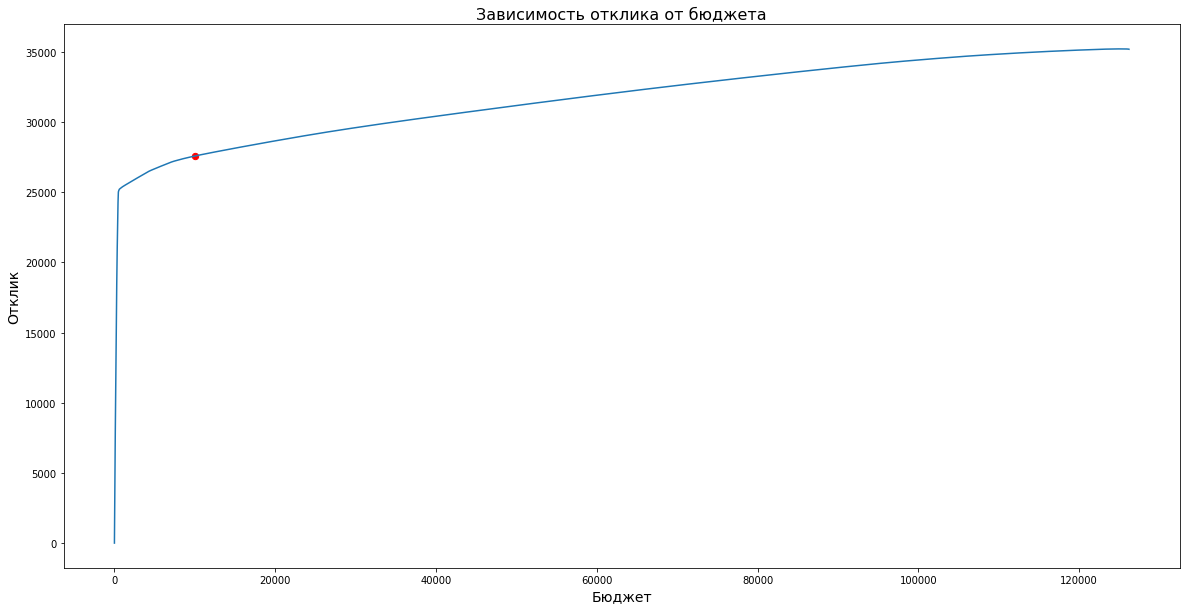

In [40]:
### Building plot ###

import matplotlib.pyplot as plt

print('Количество sms:', num_target_1)
print('Количество email:', num_target_2)
print('cut_off для sms:', cut_off_1)
print('cut_off для email:', cut_off_2)

plt.figure(figsize=(20, 10))
plt.plot(budgets, expected_responses)
plt.title('Зависимость отклика от бюджета', fontsize=16)
plt.xlabel('Бюджет', fontsize=14)
plt.ylabel('Отклик', fontsize=14)
plt.scatter(res_budget, res_response, c='red', s=40)
plt.show()